In [81]:
import json
import os
from functools import partial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import functools
import pandas as pd
import copy

width = 7
height = width / 1.618
matplotlib.rcParams.update({
    'font.size': 12,
    'figure.figsize': (width, height),
    'figure.facecolor': 'white',
    'savefig.dpi': 150,
    'figure.subplot.bottom': 0.125,
    'figure.edgecolor': 'white',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

In [2]:
def load_file(filename):
    with open(filename) as f:
        return json.load(f)

def load_dir(dir_name):
    histories = []
    fileslist = [os.path.join(dir_name, f) for f in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, f))]
    for i, filename in enumerate(fileslist):
        histories.append(load_file(filename))
    return histories

In [74]:
baseline_ori = load_file("results/baseline/histories/baseline.json")
results = load_dir("results/top_models/histories")

In [76]:
def plot_compare(histories, metrics, xmode="time", xlabel="", ylabel=None):
    for base_label, hist in histories.items():
        data = hist['data']
        kwargs = dict(
            label=hist.get('label', base_label)
        )
        kwargs.update(hist['kwargs'])
        for metric, params in metrics.items():
            if 'linestyle' not in kwargs.keys():
                kwargs.update(linestyle=params['linestyle'])
            if xmode == "time":
                plt.plot([t/60 for t in data['t_epoch_end']], data[metric], **kwargs)
            else:
                plt.plot(data[metric], **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel if ylabel is not None else ', '.join(metrics))
    plt.legend()

def stay_max(history):
    def lamb(l, e):
        if not l:
            l.append(e)
        else:
            l.append(max(l[-1], e))
        return l
    history = functools.reduce(lamb, history, [])
    return history

def apply_stay_max(history, keys):
    for key in keys:
        if key in history.keys():
            history[key] = stay_max(history[key])
    return history

def window(history, window_size):
    history = np.lib.stride_tricks.sliding_window_view(history, window_size)
    history = np.apply_along_axis(np.mean, 1, history)
    return history

def apply_window(history, keys, window_size):
    for key in keys:
        if key in history.keys():
            history[key] = window(history[key], window_size)
    history['t_epoch_end'] = history['t_epoch_end'][:-window_size+1]
    return history

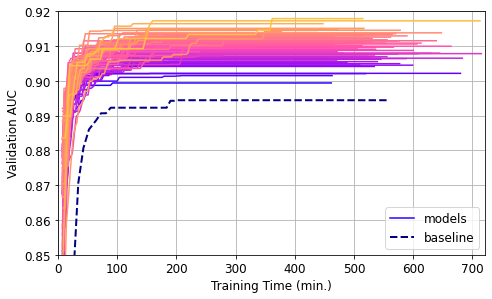

In [82]:
baseline = copy.deepcopy(baseline_ori)
top_models = copy.deepcopy(results)
top = len(top_models)
best_auc = [max(hist['val_frnn_roc']) for hist in top_models]
best_auc, top_models = zip(*list(sorted(zip(best_auc, top_models))))
best_auc = np.array(best_auc)

for m in top_models:
    m = apply_stay_max(m, ['val_frnn_roc'])
baseline = apply_stay_max(baseline, ['val_frnn_roc'])

# window_size = 5
# for m in top_models:
#     m = apply_window(m, ['val_frnn_roc'], window_size)
# baseline = apply_window(baseline, ['val_frnn_roc'], window_size)

a = best_auc.min()
b = best_auc.max()
def range_norm(val, a=0, b=1, c=0, d=1):
    val = (val-a)*(d-c)/(b-a)+c
    return val
colors = plt.cm.gnuplot2(range_norm(best_auc, a=a, b=b, c=0.3, d=0.8))

histories = {
    **{
        f'top_{i+1}': {
            'label': 'models' if i==0 else None,
            'data': top_models[i],
            'kwargs': {
                'color': colors[i],
                'alpha': 1,
            }
        } for i in range(top)
    },
    'baseline': {
        'data': baseline,
        'kwargs': {
            'color': 'navy',
            'alpha': 1,
            'linestyle': '--',
            'linewidth': 2,
        },
    }
}

metrics = {
    'val_frnn_roc': {
        'linestyle': 'solid',
    }
}

plot_compare(
    histories,
    metrics,
    xlabel="Training Time (min.)",
    ylabel="Validation AUC"
)

plt.ylim(0.85, 0.92)
plt.xlim(0, 722)
plt.grid()
plt.tight_layout()

plt.savefig("top_models_training.png")
plt.savefig("top_models_training.pdf")
plt.show()